In [1]:
# # User input
# ########################################################

# Defines the data according to the pH at which the culture was maintained
# The treatment variable can the take any of the following values: 55, 60, or 65
treatment="60" 

In [2]:
###### Libraries
import numpy as np
from scipy.integrate import odeint
import cobra
import os
import matplotlib.pyplot as plt
from scipy.special import expit
import imp 
from scipy import integrate, interpolate
from scipy.interpolate import interp1d
import pdb
from openpyxl import load_workbook
from scipy import optimize
from scipy.optimize import basinhopping
from pylab import figure, plot, xlabel, grid, legend, title, savefig
import random
from cobra.flux_analysis import flux_variability_analysis

In [3]:
%pwd

'/home/marcelo/jupyter/Cbeijerinckii/Kinetic_only/hipothesis2'

In [4]:
# Functions to load data
############################################################################################################
def rangeToArray(data_type,species,treatment):
    fileName='data/data.xlsx'
    wb = load_workbook(filename = fileName, read_only=True,data_only=True)
    ws = wb[data_type] #ws[Poblaciones|Perfiles]
    
    if data_type=="Poblaciones":
        rows={"65":[2,18],"60":[22,38],"55":[42,58],"lib":[62,75]}
        cols={"time":"B","x":"C","y":"D","z":"E"}
    elif data_type=="Perfiles":
        rows={"65":[2,18],"60":[22,37],"55":[41,58],"lib":[62,75]}
        cols={"time":"B","biomass":"C","glucose":"D","butanol":"E","acetone":"F","ethanol":"G",
      "aceticAcid":"H","butyricAcid":"I","lacticAcid":"J","isobutyricAcid":"K","formicAcid":"L","pH":"N"}
    start = cols[species]+str(rows[treatment][0])
    end   = cols[species]+str(rows[treatment][1])    
    
    x=[]
    for row in ws[start:end]:
        for cell in row:
            x.append(cell.value)
    return np.array(x)
###########################################

# Import data
t_data = rangeToArray('Poblaciones','time',treatment) # time (hrs)
x_data = rangeToArray('Poblaciones','x',treatment) # vegetative cells (g/L)
y_data = rangeToArray('Poblaciones','y',treatment) # clostrial cells (g/L)
z_data = rangeToArray('Poblaciones','z',treatment) # spores (g/L)
t_met = rangeToArray('Perfiles','time',treatment)
Ac_data = rangeToArray('Perfiles','aceticAcid',treatment)
Bc_data = rangeToArray('Perfiles','butyricAcid',treatment)
Et_data = rangeToArray('Perfiles','ethanol',treatment)
Lc_data = rangeToArray('Perfiles','lacticAcid',treatment)
pH_data = rangeToArray('Perfiles','pH',treatment)
Ae_data = rangeToArray('Perfiles','acetone',treatment)
Bl_data = rangeToArray('Perfiles','butanol',treatment)
G_data = rangeToArray('Perfiles','glucose',treatment)
# Interpolate data
x_int  = interpolate.interp1d(t_data, x_data)
y_int  = interpolate.interp1d(t_data, y_data)
z_int  = interpolate.interp1d(t_data, z_data)
Ac_int = interpolate.interp1d(t_met,Ac_data)
Bc_int = interpolate.interp1d(t_met,Bc_data)
Et_int = interpolate.interp1d(t_met,Et_data)
Lc_int = interpolate.interp1d(t_met,Lc_data)
pH_int = interpolate.interp1d(t_met,pH_data)
Ae_int = interpolate.interp1d(t_met,Ae_data)
Bl_int = interpolate.interp1d(t_met,Bl_data)
G_int  = interpolate.interp1d(t_met,G_data) # or Rbf or interp1d
   
# Miscelaneous functions

# Save results along the fermentation path
###############################################################################################
def resetPath(X,Y,Z,G,Ac,Bc,Lc,Et,Ae,Bl,deltax,deltay,f):
    global X_path,Y_path,Z_path
    global G_path,Et_path,Ac_path,Bc_path,Lc_path,Ae_path,Bl_path
    global deltax_path, deltay_path
    global f_path
    X_path,Y_path, Z_path   = np.array([X]),np.array([Y]),np.array([Z])
    G_path,Et_path,Ac_path  = np.array([G]),np.array([Et]),np.array([Ac])
    Bc_path,Lc_path,Ae_path,Bl_path = np.array([Bc]),np.array([Lc]),np.array([Ae]),np.array([Bl])
    deltax_path,deltay_path = np.array([deltax]),np.array([deltay])
    f_path = [f]
    
def savePath(X,Y,Z,G,Ac,Bc,Lc,Et,Ae,Bl,deltax,deltay,f):
    global X_path,Y_path,Z_path
    global G_path,Et_path,Ac_path,Bc_path,Lc_path,Ae_path,Bl_path
    global deltax_path, deltay_path
    global f_path
    X_path = np.append(X_path,X)
    Y_path = np.append(Y_path,Y)
    Z_path = np.append(Z_path, Z)
    G_path = np.append(G_path, G)
    Et_path = np.append(Et_path, Et)
    Ac_path = np.append(Ac_path, Ac)
    Bc_path = np.append(Bc_path, Bc)
    Lc_path = np.append(Lc_path, Lc)
    Ae_path = np.append(Ae_path, Ae)
    Bl_path = np.append(Bl_path, Bl)
    deltax_path = np.append(deltax_path, deltax)
    deltay_path = np.append(deltay_path, deltay)
    f_path = np.append(f_path , f)
    
def resetFluxes():
    global xfluxes_path, yfluxes_path
    xfluxes_path, yfluxes_path = [],[]
def saveFluxes(xfluxes,yfluxes):
    global xfluxes_path, yfluxes_path
    xfluxes_path.append(xfluxes)
    yfluxes_path.append(yfluxes)
    
# Dynamic block
def diffEqs(var,time,deParams):
    X,Y,Z,G,Ac,Bc,Lc,Ae,Bl,Et = var # Current values
    mux,vGx,vLcx,vBcx,vBlx,vAcx,vAex,vEtx = deParams["X"] # X's metabolic parameters
    muy,vGy,vLcy,vBcy,vBly1,vBly2,vAcy,vAey,vEty = deParams["Y"] # Y's metabolic parameters
    tx,ty,dx,dy,pix,piy,deltax,deltay,c = deParams["pop"] # populations parameters
    derivs = [(mux*(1-dx)*(1-tx) - pix*(1-dx)*tx - deltax*dx )*X,  # dXdt
              (muy*(1-dy)*(1-ty) - piy*(1-dy)*ty - deltay*dy )*Y + pix*(1-dx)*tx*X,  # dYdt
              c*piy*(1-dy)*ty*Y,              # dZdt
              vGx *mux*X*(1-dx)*(1-tx)  + vGy*muy*Y*(1-dy)*(1-ty),     # dGdt
              vAcx*mux*X*(1-dx)*(1-tx) + vAcy*muy*Y*(1-dy)*(1-ty),    # dAcdt
              vBcx*mux*X*(1-dx)*(1-tx) + vBcy*muy*Y*(1-dy)*(1-ty),    # dBcdt
              vLcx*mux*X*(1-dx)*(1-tx) + vLcy*muy*Y*(1-dy)*(1-ty),    # dLcdt
              vAex*mux*X*(1-dx)*(1-tx) + vAey*muy*Y*(1-dy)*(1-ty),    # dAedt
              vBlx*mux*X*(1-dx)*(1-tx) + (vBly1*muy + vBly2)*Y*(1-dy)*(1-ty),    # dBldt
              vEtx*mux*X*(1-dx)*(1-tx) + vEty*muy*Y*(1-dy)*(1-ty)]    # dEtdt    
    return derivs
def getFluxes(var,deParams):
    X,Y,Z,G,Ac,Bc,Lc,Ae,Bl,Et = var # Current values
    mux,vGx,vLcx,vBcx,vBlx,vAcx,vAex,vEtx = deParams["X"] # X's metabolic parameters
    muy,vGy,vLcy,vBcy,vBly1,vBly2,vAcy,vAey,vEty = deParams["Y"] # Y's metabolic parameters
    tx,ty,dx,dy,pix,piy,deltax,deltay,c = deParams["pop"] # populations parameters    
    xfluxes=[ mux*(1-dx)*(1-tx),  # muX
               vGx *mux*(1-dx)*(1-tx),  # vGx  
               vAcx*mux*(1-dx)*(1-tx),  # vAc
               vBcx*mux*(1-dx)*(1-tx),    # vBc
               vLcx*mux*(1-dx)*(1-tx),    # vLc
               vAex*mux*(1-dx)*(1-tx),    # vAe
               vBlx*mux*(1-dx)*(1-tx),    # vBl
               vEtx*mux*(1-dx)*(1-tx)]    # vEt              
    yfluxes= [muy*(1-dy)*(1-ty),  # muY
              vGy*muy*(1-dy)*(1-ty),     # vG
              vAcy*muy*(1-dy)*(1-ty),    # vAc
              vBcy*muy*(1-dy)*(1-ty),    # vBc
              vLcy*muy*(1-dy)*(1-ty),    # vLc
              vAey*muy*(1-dy)*(1-ty),    # vAe
              (vBly1*muy + vBly2)*(1-dy)*(1-ty),    # vBl
              vEty*muy*(1-dy)*(1-ty)]    # vEt
    MWs = np.array([1,0.18,.0600,.0881,0.0901,.0590,0.0741,.046]) # g/mmol X,G,Ac,Bc,Lc,Ae,Bl,Et
    xfluxes = xfluxes/MWs # mmol/g/h
    yfluxes = yfluxes/MWs # mmol/g/h
    return xfluxes,yfluxes 

def dynamicBlock(var,deParams, ti,tf):
    time=np.linspace(ti,tf,10)
    soln = odeint(diffEqs,var,time,args=(deParams,))
    result=soln[-1,:]
    result[result<0]=0
    return result # X,Y,Z,G,Ac,Bc,Et,Ae,Bl

def predFunc(time,idx_data,idx_met,guess):

    KBlx,kBlx,KBly,kBly,KBc,KBcI,KLc, \
    muxM,muyM, \
    KG, \
    fx,fy, \
    dxM,dyM, \
    pix,piy,c, \
    vGX,vGY, \
    vAcX,vAcY, \
    vBcX,vBcY, \
    vLcX,vLcY, \
    vAeY, \
    vBlY1,vBlY2, \
    vEtY = guess

    # Initial conditions
    ###############################################################################################
    j=time[0]
    G, Et,Ac,Bc,Lc,Ae,Bl = G_int(j), Et_int(j),Ac_int(j),Bc_int(j),Lc_int(j),Ae_int(j),Bl_int(j) # metabolites concentrations
    X,Y,Z=x_int(j),y_int(j),z_int(j)# phenotypes
    deParams={} # dictionary to store the parameters of the differential equations
    # Running simulation
    ###############################################################################################
    for i in range(len(time)):
                
        mux = muxM*G/(G+KG)* KBcI/(KBcI+Bc) 
        muy = muyM*G/(G+KG)* Bc/(KBc+Bc+Bc**2/KBcI) * Lc/(KLc+Lc)

        tx,ty = fx,fy
        deltax,deltay = dxM,dyM
        dx = expit(KBlx*(Bl-kBlx))
        dy = expit(KBly*(Bl-kBly))
        
        shift= (1-expit(0.5*(time[i]-18))) + expit(0.5*(time[i]-38))

        vGx,vGy  = -vGX,-vGY
        vAcx,vAcy = vAcX,-vAcY
        vBcx,vBcy = vBcX *(shift),-vBcY
        vLcx,vLcy =  vLcX*(1-shift), -vLcY 
        vAex,vAey = 0,vAeY
        vBlx,vBly1,vBly2 = 0,vBlY1,vBlY2
        vEtx,vEty = 0,vEtY        
   
        ###############################################################################################
        # Saves results along the fermentaion path
        savex = mux*(1-dx)*(1-tx)
        savey = muy*(1-dy)*(1-ty)
        if i==0: 
            resetPath(X,Y,Z,G,Ac,Bc,Lc,Et,Ae,Bl,savex,savey,0)
            resetFluxes()
        else:
            j=time[i]
            #G,Ac,Bc,Lc,Ae,Bl,Et = G_int(j),Ac_int(j),Bc_int(j),Lc_int(j),Ae_int(j),Bl_int(j),Et_int(j) # metabolites concentrations
            savePath( X,Y,Z,G,Ac,Bc,Lc,Et,Ae,Bl,savex,savey,mux)
            saveFluxes(xfluxes,yfluxes)
        #  Dynamic block, predict future stae
        ###############################################################################################
        if i==len(time)-1: continue # avoids predicting beyond the last time-point
        var = [ X,Y,Z,G,Ac,Bc,Lc,Ae,Bl,Et ]
        deParams["X"]   = [ mux,vGx,vLcx,vBcx,vBlx,vAcx,vAex,vEtx ] # metabolic parameters of X
        deParams["Y"]   = [ muy,vGy,vLcy,vBcy,vBly1,vBly2,vAcy,vAey,vEty ] # metabolic parameters of Y
        deParams["pop"] = [ tx,ty,dx,dy,pix,piy,deltax,deltay,c ] # populations parameters
        X,Y,Z,G,Ac,Bc,Lc,Ae,Bl,Et = dynamicBlock(var, deParams, time[i],time[i+1])
        # get fluxes
        xfluxes, yfluxes = getFluxes(var,deParams)

    return [ X_path[idx_data],Y_path[idx_data],Z_path[idx_data],G_path[idx_met],Ac_path[idx_met],Bc_path[idx_met],Lc_path[idx_met],Et_path[idx_met],Ae_path[idx_met],Bl_path[idx_met] ]

# Inital values for the search of the parameters' values

if treatment=="55":
    KBlx = 0.5177310343506208
    kBlx = 0.500626630190563
    KBly = 0.5044953370667166
    kBly = 0.023608929318825255
    KBc = 4.688496307314794
    KBcI = 3.246721797804927
    KLc = 5.231436260416712
    muxM = 0.8399643942337095
    muyM = 5.945732966362721
    KG = 2.120471967407676
    fx = 0.07255589575783727
    fy = 0.38395468384435844
    dxM = 0.04439970962103253
    dyM = 0.009110145203408412
    pix = 4.795904653506116
    piy = 0.9030467094414166
    c = 0.20179816262404746
    vGX = 3.0113202458622825
    vGY = 2.7375825092797115
    vAcX = 0.3376002273870112
    vAcY = 2.393901694913814
    vBcX = 0.42587979304640516
    vBcY = 0.382680203280984
    vLcX = 0.621637946989061
    vLcY = 5.184728155209933
    vAeY = 2.720496586414521
    vBlY1 = 3.003120393745479
    vBlY2 = 0.5534752492086644
    vEtY = 0.1864136686776434
elif treatment=="65":
    KBlx = 0.3939410940382379
    kBlx = 0.31611869084696176
    KBly = 1.9949858741355175
    kBly = 7.735881729154995
    KBc = 2.5121602349370438
    KBcI = 1.6994105471823981
    KLc = 4.573759198345996
    muxM = 0.8894441685719153
    muyM = 2.8137345391242916
    KG = 0.371574417982349
    fx = 0.11121571247711975
    fy = 0.04699988397924688
    dxM = 0.027183527104893822
    dyM = 0.009634192641502292
    pix = 2.224109881430163
    piy = 2.6437115368947195
    c = 0.29538920478889846
    vGX = 5.674136386635634
    vGY = 2.9917637132729156
    vAcX = 0.6615425745672453
    vAcY = 1.1113561422779763
    vBcX = 0.8382019672908836
    vBcY = 0.3097499799209138
    vLcX = 1.018211671928835
    vLcY = 1.9052347747794265
    vAeY = 0.9919798927049157
    vBlY1 = 1.2912126696749766
    vBlY2 = 0.21599511889115752
    vEtY = 0.16919930902429844
elif treatment=="60":
    KBlx = 0.3879271674652318
    kBlx = 0.0021282004836683417
    KBly = 0.6122454220633851
    kBly = 2.9594056585963067
    KBc = 0.6586899508406833
    KBcI = 2.1988395021878113
    KLc = 1.0614343692993198
    muxM = 2.2802476884823735
    muyM = 4.046401173323333
    KG = 1.0591541632705994
    fx = 0.374770246999414
    fy = 0.7247204384771866
    dxM = 0.03713273250983689
    dyM = 0.0192287826177931
    pix = 1.566607879190209
    piy = 1.0238710722972189
    c = 0.16043306953414255
    vGX = 3.275312071641041
    vGY = 2.2913930527685116
    vAcX = 0.4592319221319047
    vAcY = 1.6048782887869886
    vBcX = 0.44623420219864246
    vBcY = 0.35988929912727813
    vLcX = 1.2010915402068145
    vLcY = 2.9186234162381592
    vAeY = 0.8349406443930432
    vBlY1 = 1.8265273487500693
    vBlY2 = 1.328775783925787
    vEtY = 0.09821478313442439
    vEtY = 0.03858824965245977

guess= [KBlx,kBlx,KBly,kBly,KBc,KBcI,KLc, \
        muxM,muyM, \
        KG, \
        fx,fy, \
        dxM,dyM, \
        pix,piy,c, \
        vGX,vGY, \
        vAcX,vAcY, \
        vBcX,vBcY, \
        vLcX,vLcY, \
        vAeY, \
        vBlY1,vBlY2, \
        vEtY ] 

# Objective function
#############################################################################
def diffNorm(pred,data):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    sumT = 0.0
    for i in range(len(data)):
        diff_i = (pred[i]-data[i])/np.max(data[i])
        sumT += np.sum(np.square( diff_i ))
    return sumT
def lws(guess):
    if treatment=="55":
        # Exponential growth phase starts at the first measurement 
        data=[x_data,y_data,z_data,G_data,Ac_data,Bc_data,Lc_data,Et_data,Ae_data,Bl_data ]
    else:
        # Exponential growth phase starts after the 10th measurement
        data=[x_data[t_data>10],y_data[t_data>10],z_data[t_data>10],G_data[t_met>10],Ac_data[t_met>10],
                      Bc_data[t_met>10],Lc_data[t_met>10],Et_data[t_met>10],Ae_data[t_met>10],Bl_data[t_met>10] ]

    pred=predFunc(time,idx_data,idx_met,guess)
    if pred is None:
        objective = 1e9
    else:
        objective = diffNorm(pred,data)
    
    global globalCounter
    globalCounter += 1

    return objective

# Optimization function
#############################################################################
class MyTakeStep(object):
    """random displacement with bounds"""
    def __init__(self, xmin=[0.00001]*29, xmax=[20]*29, stepsize=1):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        """take a random step but ensure the new position is within the bounds"""
        rando = np.random.uniform(-self.stepsize, self.stepsize, np.shape(x))
        xnew = np.clip( x + rando, self.xmin, self.xmax )
        return xnew
def print_fun(x, f, accepted): 
    print("at minimum %.4f accepted %d" % (f, int(accepted)))    
    names=['KBlx','kBlx','KBly','kBly','KBc','KBcI','KLc',
            'muxM','muyM',
            'KG',
            'fx','fy',
            'dxM','dyM',
            'pix','piy','c',
            'vGX','vGY', \
            'vAcX','vAcY', \
            'vBcX','vBcY', \
            'vLcX','vLcY', \
            'vAeY', \
            'vBlY1','vBlY2', \
            'vEtY']
    global globalCounter, bhCounter,outFile
    globalCounter=0
    bhCounter += 1
    outFile.write("============================")    
    outFile.write(bhCounter, f, treatment)
    outFile.write("============================")
    for i in zip(names,x):
        outFile.write( i[0]+" = "+str(i[1]) )
        
xmin=[0.00001]*29
xmax=[20.0]*29
bounds = [(low, high) for low, high in zip(xmin, xmax)]
minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
mytakestep = MyTakeStep()

np.random.seed(15)

# outFile = open("results"+treatment+".txt","w",buffering=0)
# if treatment=="55":
#     timeRange=np.linspace(max(min(t_data),min(t_met)),min(max(t_data),max(t_met)),100)
# else:
#     timeRange=np.linspace(10,min(max(t_data),max(t_met)),100)
# t_data_obs=np.array(t_data)[np.array(t_data)>=min(timeRange)]
# t_met_obs=np.array(t_met)[np.array(t_met)>=min(timeRange)]
# time=np.sort(np.unique(np.concatenate((t_data_obs,t_met_obs,timeRange))))   
# idx_data=np.intersect1d(time, t_data_obs,return_indices=True)[1]
# idx_met=np.intersect1d(time, t_met_obs,return_indices=True)[1]

# globalCounter=0
# bhCounter=0
# sol = basinhopping(lws, guess, niter=100,disp=True,
#                   take_step=mytakestep,minimizer_kwargs=minimizer_kwargs,callback=print_fun)
# # Print final result
# print >>outFile, "============================" 
# print >>outFile, "FINAL RESULT"
# print >>outFile, "============================" 
# print >>outFile, str(sol)

# outFile.close()

0.8573672574558097


<Figure size 432x288 with 0 Axes>

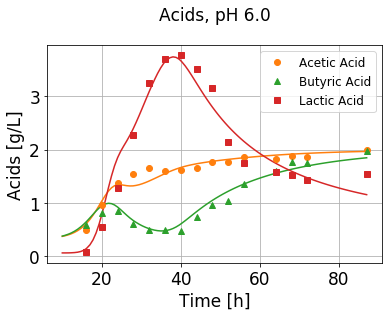

<Figure size 432x288 with 0 Axes>

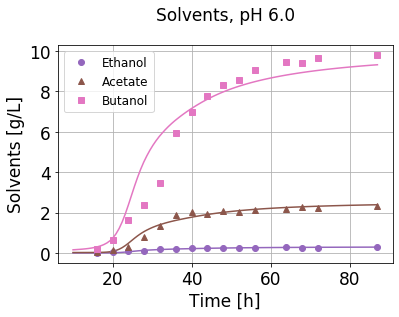

<Figure size 432x288 with 0 Axes>

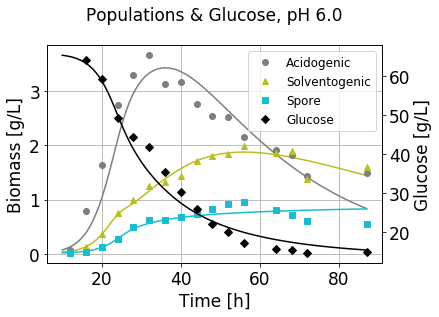

In [5]:
# PLOT THE RESULTS

# Display parameters
size=17
params = {'legend.fontsize': 12,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params)
def doPlots():
    treatmentName={"65":"6.5","60":"6.0","55":"5.5"}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    t_metr = t_met[t_met>=min(time)]
    G_datar = G_data[t_met>=min(time)]
    Ac_datar = Ac_data[t_met>=min(time)]
    Bc_datar = Bc_data[t_met>=min(time)]
    Lc_datar = Lc_data[t_met>=min(time)]
    Et_datar = Et_data[t_met>=min(time)]
    Ae_datar = Ae_data[t_met>=min(time)]
    Bl_datar = Bl_data[t_met>=min(time)]
    t_datar = t_data[t_data>=min(time)]
    x_datar = x_data[t_data>=min(time)]
    y_datar = y_data[t_data>=min(time)]
    z_datar = z_data[t_data>=min(time)]
    
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.plot(time,Ac_path,color=colors[1])
    ax1.plot(time,Bc_path,color=colors[2])
    ax1.plot(time,Lc_path,color=colors[3])
    ax1.plot(t_metr,Ac_datar,'o',label="Acetic Acid",color=colors[1])
    ax1.plot(t_metr,Bc_datar,'^',label="Butyric Acid",color=colors[2])
    ax1.plot(t_metr,Lc_datar,'s',label="Lactic Acid",color=colors[3])    
    ax1.legend()
    ax1.set_title("Acids, pH "+treatmentName[treatment])
    ax1.set_ylabel('Acids [g/L]')
    ax1.set_xlabel('Time [h]')
    ax1.grid()
    plt.savefig("acids_"+treatment+".svg")

    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.plot(time,Et_path,color=colors[4])
    ax1.plot(time,Ae_path,color=colors[5])
    ax1.plot(time,Bl_path,color=colors[6])
    ax1.plot(t_metr,Et_datar,'o',label="Ethanol",color=colors[4])
    ax1.plot(t_metr,Ae_datar,'^',label="Acetate",color=colors[5])
    ax1.plot(t_metr,Bl_datar,'s',label="Butanol",color=colors[6])    
    ax1.legend()
    ax1.set_title("Solvents, pH "+treatmentName[treatment])
    ax1.set_ylabel('Solvents [g/L]')
    ax1.set_xlabel('Time [h]')
    ax1.grid()
    plt.savefig("solvents_"+treatment+".svg")


    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.plot(time,X_path,color=colors[7])
    ax1.plot(time,Y_path,color=colors[8])
    ax1.plot(time,Z_path,color=colors[9])
    ax1.plot(t_datar,x_datar,'o',label="Acidogenic",color=colors[7])
    ax1.plot(t_datar,y_datar,'^',label="Solventogenic",color=colors[8])
    ax1.plot(t_datar,z_datar,'s',label="Spore",color=colors[9])
    ax1.grid()
    ax1.set_title("Populations & Glucose, pH "+treatmentName[treatment])
    ax1.set_ylabel('Biomass [g/L]')
    ax1.set_xlabel('Time [h]')
    ax2 = ax1.twinx()
    ax2.plot(time,G_path,color="k")
    ax2.plot(t_metr,G_datar,'D',label="Glucose",color="k")
    ax2.set_ylabel('Glucose [g/L]') 
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.savefig("populations_"+treatment+".svg")

# These are the results used in the manuscript
    
if treatment=="55":
    KBlx = 0.5153285484288662
    kBlx = 0.10313815615891203
    KBly = 1.034246547052368
    kBly = 1.67184396769703
    KBc = 4.2062996685291845
    KBcI = 4.019385583209013
    KLc = 4.360421925014468
    muxM = 0.7976248960771375
    muyM = 6.267607203840323
    KG = 1.6830751092156233
    fx = 0.04830348542111517
    fy = 0.09750281741676153
    dxM = 0.04083015265753388
    dyM = 0.01924495007101897
    pix = 6.182797919181271
    piy = 1.4753758316784473
    c = 0.509929385107832
    vGX = 3.914481916313192
    vGY = 2.783039347291248
    vAcX = 0.27316692517954055
    vAcY = 0.1326418909324314
    vBcX = 0.44300273706235915
    vBcY = 1e-05
    vLcX = 1.7708365015783418
    vLcY = 7.156766383922476
    vAeY = 1.7755886417760762
    vBlY1 = 4.295311914287171
    vBlY2 = 0.18216489957842785
    vEtY = 0.10697929460936735
elif treatment=="60":
    KBlx = 0.40130783029144557
    kBlx = 1e-05
    KBly = 0.8748881086622972
    kBly = 4.195909125085701
    KBc = 1.0004018993138977
    KBcI = 6.101042582800913
    KLc = 4.531268339687365
    muxM = 2.3351638266130834
    muyM = 7.916077437062856
    KG = 1e-05
    fx = 0.38828336280963544
    fy = 0.8410322728768647
    dxM = 0.04674548312101767
    dyM = 0.016204424301708674
    pix = 1.7522886226306253
    piy = 0.8568331485963685
    c = 0.11238632624469935
    vGX = 2.8890548545671044
    vGY = 2.564540411549464
    vAcX = 0.3372748743656029
    vAcY = 2.5319822528332043
    vBcX = 0.4215329293524332
    vBcY = 0.7810687879044587
    vLcX = 1.1777764421608343
    vLcY = 6.904084092735192
    vAeY = 1.5801957966485463
    vBlY1 = 3.8507725888739666
    vBlY2 = 2.129974885121485
    vEtY = 0.1918254205430311    
elif treatment=="65":
    KBlx = 0.43043050555137136
    kBlx = 0.04351045895479553
    KBly = 2.9341752598584465
    kBly = 7.828552195598106
    KBc = 3.7727172203898807
    KBcI = 3.2166473970898974
    KLc = 4.732965751923197
    muxM = 0.9979534890964448
    muyM = 2.0219911607009875
    KG = 0.23681229535753257
    fx = 0.13220556195373406
    fy = 0.03474654863015857
    dxM = 0.024032548205035604
    dyM = 0.009634567565137685
    pix = 2.464980890390457
    piy = 2.86882037368887
    c = 0.2476624872966846
    vGX = 5.573339413224136
    vGY = 3.885728563583512
    vAcX = 0.5459294152640042
    vAcY = 1.1891001076339947
    vBcX = 0.8548878966930769
    vBcY = 0.37931683276385636
    vLcX = 0.9436977967386222
    vLcY = 2.659700502528754
    vAeY = 1.4325490970581354
    vBlY1 = 1.582028422503917
    vBlY2 = 0.20478929142841276
    vEtY = 0.24061316055352544
     
params= [KBlx,kBlx,KBly,kBly,KBc,KBcI,KLc, \
        muxM,muyM, \
        KG, \
        fx,fy, \
        dxM,dyM, \
        pix,piy,c, \
        vGX,vGY, \
        vAcX,vAcY, \
        vBcX,vBcY, \
        vLcX,vLcY, \
        vAeY, \
        vBlY1,vBlY2, \
        vEtY]    

if treatment=="55":
    timeRange=np.linspace(max(min(t_data),min(t_met)),min(max(t_data),max(t_met)),100)
    data=[x_data,y_data,z_data,G_data,Ac_data,Bc_data,Lc_data,Et_data,Ae_data,Bl_data ]
else:
    timeRange=np.linspace(10,min(max(t_data),max(t_met)),100)
    data=[x_data[t_data>10],y_data[t_data>10],z_data[t_data>10],G_data[t_met>10],Ac_data[t_met>10],
                  Bc_data[t_met>10],Lc_data[t_met>10],Et_data[t_met>10],Ae_data[t_met>10],Bl_data[t_met>10] ]
    
t_data_obs=np.array(t_data)[np.array(t_data)>=min(timeRange)]
t_met_obs=np.array(t_met)[np.array(t_met)>=min(timeRange)]
time=np.unique(np.sort(np.concatenate((t_data_obs,t_met_obs,timeRange)))) 
idx_data=np.intersect1d(time, t_data_obs,return_indices=True)[1]
idx_met=np.intersect1d(time, t_met_obs,return_indices=True)[1]
    
    
pred=predFunc(time,idx_data,idx_met,params)

print( diffNorm(pred,data) )
doPlots()   

In [6]:
# STOICHIOMETRIC MODEL

# Load genome-scale metabolic network of Milne et al (2011)
# from: https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-5-130
model=cobra.io.read_sbml_model("data/12918_2011_738_MOESM3_ESM.XML")

# Allows lactate exchange reaction consume lactate
model.reactions.get_by_id("LAC2ex").bounds=(-1000,1000)
modelX=model.copy() # Copy for the acidogenic cell types
modelY=model.copy() # Copy for the solventogenic cell types

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_c "10fthf[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_12dgr_CB_c "12dgr_CB[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_12ethd_c "12ethd[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_12ppd_c "12ppd[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_12ppd_R_c "12ppd-R[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_13dpg_c "13dpg[c]">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Spe

In [7]:
# SET THE REACTIONS THAT COMPOSE THE VARIOUS PATHWAYS STUDIED IN THE MANUSCRIPT


# Reactions of the glycolysis pathway that consume NAD
glyNADrxns = {"GAPD":-1}
# Lactate dehydrogenas
lacNADrxns = {"LDH_L":-1,"LDH_D":-1}
# Ferredoxin NAD reductase
ferNADrxns = {"FDXNRx":-1}
# H2 production
h2rxns = {"FDXNH":1}

# Reactions that consume (-1) or produce (1) NAD
# On acidogenic cell types
aciNADrxns = {"LDH_L":-1,"LDH_D":-1,"FDXNRx":-1,"HACD1y":1,"ACOAD1":1} # acids
# On solvlentogenic cell types
solNADrxns = {"LDH_L":-1,"LDH_D":-1,"FDXNRx":-1,"HACD1y":1,"ACOAD1":1,"ACALD":-1,"ALCD2":-1,"BUTOHDx":1} # solvents
# Various other reactions related to NAD
varNADrxns = {"LDH_L":-1,"LDH_D":-1,"FDXNRx":-1,"FDXNH":1, "HACD1y":1, "ACOAD1":1}

# Reactions that consume (-1) or produce (1) ATP
# On acidogenic cell types
aciATPrxns = {"ACK":1,"BUTK":1} # acids
# On solvlentogenic cell types
solATPrxns = {"ACK":1,"BUTK":1} # solvents
# On glycolysis pathway
glyATPrxns = {"GLCabc":-1,"HEX1":-1,"PFK":-1,"PGK":-1,"PYK":1}

# Biomass reaction
biomassRxn = {"biomass":1}

# All reactions in the metabolic network that consume (-1) or produce (1) NAD
allNADrxns = {}
nad_c = model.metabolites.nad_c
for reaction in model.reactions:
    if nad_c in reaction.metabolites:
        allNADrxns[reaction.id] = reaction.metabolites[nad_c]

# All reactions in the metabolic network that consume (-1) or produce (1) ATP
allATPrxns = {}
atp_c = model.metabolites.atp_c
for reaction in model.reactions:
    if atp_c in reaction.metabolites:
        allATPrxns[reaction.id] = reaction.metabolites[atp_c]        

# Save all pathways into a dictionary
pathways = {"GlycolisisNAD":glyNADrxns,"AcidsPathwaysNAD": aciNADrxns,"SolventsPathwaysNAD": solNADrxns,
            "LactateDehydrogenases":lacNADrxns,"FerredoxinNADreductase":ferNADrxns ,
            "WholeMetabolismNAD":allNADrxns,"VariousReactions":varNADrxns,"Biomass":biomassRxn,
            "GlycolisisATP":glyATPrxns,"AcidsPathwaysATP": aciATPrxns,"SolventsPathwaysATP": solATPrxns,
           "WholeMetabolismATP":allATPrxns,"h2rxns":h2rxns}

In [8]:
# Compute FVA ranges for acidogenic and solventogenic cell types
def getMetabolism(phenotype,model,fluxes,reaction,i): 
    mu, vG,vAc,vBc,vLc,vAe,vBl,vEt = fluxes
    if phenotype == "X":
        model.reactions.get_by_id("ex_glc_D_e").bounds =  (vG, vG) # Glucose
        # Acidic metabolites
        model.reactions.get_by_id("ex_but_e").bounds = (vBc,vBc) # Butyrate, Butyric Acid
        model.reactions.get_by_id("ex_ac_e").bounds = (vAc,vAc)  # Acetate, Acetic Acid
        model.reactions.get_by_id("ex_lac_L_e").bounds = (vLc,vLc) # Lactate, Lactic Acid        
        # Solventogenic metabolites
        model.reactions.get_by_id("ex_etoh_e").bounds = (0,0)  # Ethanol
        model.reactions.get_by_id("ex_butoh_e").bounds =(0,0) # Butanol
        model.reactions.get_by_id("ex_acetone_e").bounds = (0,0) # Acetone
        sln = model.optimize() 
        if sln.status =="infeasible": print(sln.status)         
        bounds=flux_variability_analysis(model, list(reactions.keys()) )
    elif phenotype == "Y":
        model.reactions.get_by_id("ex_glc_D_e").bounds = (vG,vG) # Glucose
        # Acidic metabolites
        model.reactions.get_by_id("ex_but_e").bounds   = (vBc,vBc) # Butyrate, Butyric Acid
        model.reactions.get_by_id("ex_ac_e").bounds    = (vAc,vAc)  # Acetate, Acetic Acid
        model.reactions.get_by_id("ex_lac_L_e").bounds = (-1000,vLc) # Lactate, Lactic Acid
        # Solventogenic metabolites
        model.reactions.get_by_id("ex_etoh_e").bounds    = (vEt,vEt)  # Ethanol
        model.reactions.get_by_id("ex_butoh_e").bounds   = (vBl,vBl) # Butanol
        model.reactions.get_by_id("ex_acetone_e").bounds = (vAe,vAe) # Acetone        
        sln = model.optimize()
        status = sln.status
        if status =="infeasible": 
            print(sln.status)   
        bounds=flux_variability_analysis(model, list(reactions.keys()) )
    return bounds

def getBounds(phenotype,fluxes_path,model,reactions):  
    boundS=[]
    for i,fluxes in enumerate(fluxes_path):
        bounds = getMetabolism(phenotype,model,fluxes,reactions,i)
        boundS.append(bounds)
    return boundS

def getFluxes(reaction,direction,boundS):
    direction= float(direction)
    means,lbs,ubs = [],[],[]
    for bounds in boundS:
        upper = direction*bounds.loc[reaction]["maximum"]
        lower = direction*bounds.loc[reaction]["minimum"]
        if lower>upper: # shift upper and lower
            tmp = upper
            upper = lower
            lower = tmp
        average = (lower+upper)*0.5
        if (lower-upper)>10:
            print(reaction,lower,average,upper,direction)
        means.append(average)
        lbs.append(lower)
        ubs.append(upper) 
    return np.array(means),np.array(lbs),np.array(ubs) 

In [9]:
# Compute FVA ranges for a given pathway

# The variable pathName can be any key in the pathways dictionary.
# For instance, to compute the production of NAD by the whole metabolisms
# use pathway = "WholeMetabolismNAD"

pathName="WholeMetabolismNAD" #"SolventsPathwaysNAD"
reactions=pathways[pathName]

boundsXWM = getBounds("X",xfluxes_path,modelX,reactions)
boundsYWM = getBounds("Y",yfluxes_path,modelY,reactions)

# Get positive production
posProdX = 0
posProdY = 0
ubPosProdX = 0
lbPosProdX = 0
ubPosProdY = 0
lbPosProdY = 0 
for reaction in reactions:
    direction = reactions[reaction]
    meanXs,lbXs,ubXs = getFluxes(reaction,direction,boundsXWM)
    meanYs,lbYs,ubYs = getFluxes(reaction,direction,boundsYWM)
    meanXs[meanXs<0] = 0
    meanYs[meanYs<0] = 0
    ubXs[ubXs<0] = 0
    ubYs[ubYs<0] = 0
    lbXs[lbXs<0] = 0
    lbYs[lbYs<0] = 0

    posProdX += meanXs
    posProdY += meanYs 
    ubPosProdX += ubXs
    lbPosProdX += lbXs        
    ubPosProdY += ubYs
    lbPosProdY += lbYs   
    
# In case the pathway is set to "Biomass", the following code will plots the
# biomass growth rates computed by the stoichiometric and kinetic models

if pathName == "Biomass":
    boundsX = getBounds("X",xfluxes_path,modelX,reactions)
    boundsY = getBounds("Y",yfluxes_path,modelY,reactions)        
    # Get net production of NAD
    for i,reaction in enumerate(reactions):
        direction = reactions[reaction]
        meanXs,lbXs,ubXs = getFluxes(reaction,direction,boundsX)
        meanYs,lbYs,ubYs = getFluxes(reaction,direction,boundsY)    
        #Plot by reaction
        plt.figure()
        plt.fill_between(time[1:],lbXs, ubXs,color="grey",alpha=0.5)
        plt.plot(time[1:],meanXs, color="red",label="Kinetic block, acidogenic")
        plt.ylabel("Flux [mmol/gDW/h]")
        plt.xlabel("Time [h]")    
        plt.fill_between(time[1:],lbYs, ubYs,color="grey",alpha=0.5)
        plt.plot(time[1:],meanYs, color="green",label="Kinetic block, solventogenic")
        plt.ylabel("A. specific growth rate [1/h]")
        plt.xlabel("Time [h]")    
        plt.grid()    
        
        plt.plot(time,deltax_path,color="red",linestyle="--",label="Stoichiometric block, acidogenic")
        plt.plot(time,deltay_path,color="green",linestyle="--",label="Stoichiometric block, solventogenic")
        plt.legend()        
        
        plt.savefig(reaction+"_"+pathName+"_XY.png")

        # Plot fractions by reaction 
        fracX=meanXs/posProdX*100    
        fracY=meanYs/posProdY*100 
        lbFracX = lbXs/ubPosProdX*100
        ubFracX = ubXs/lbPosProdX*100
        lbFracY = lbYs/ubPosProdY*100
        ubFracY = ubYs/lbPosProdY*100    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.

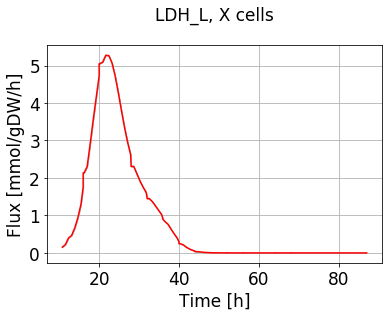

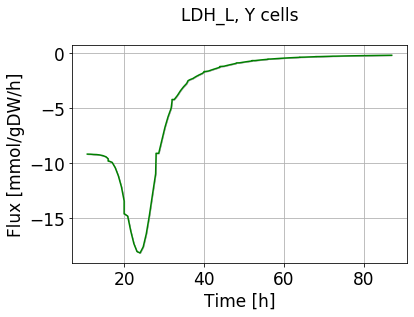

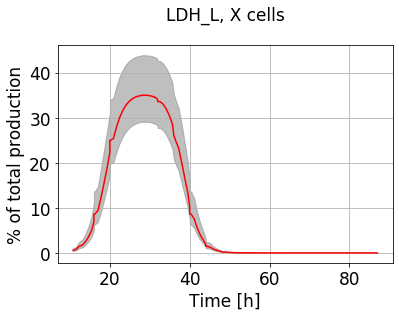

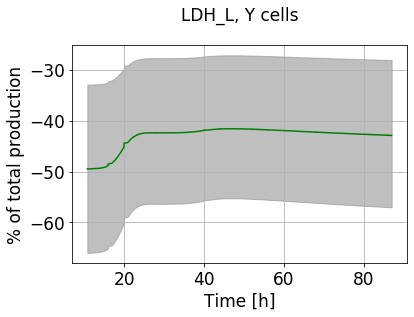

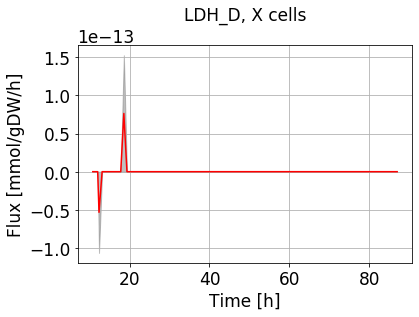

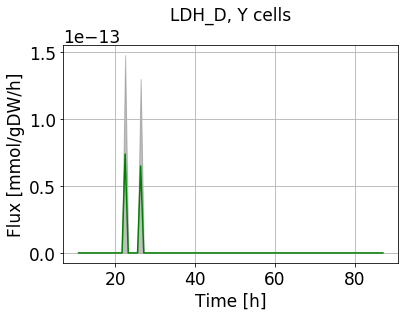

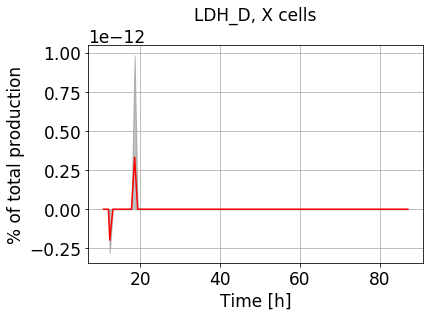

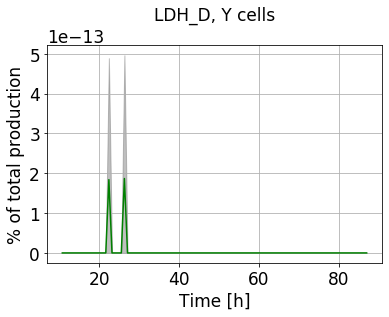

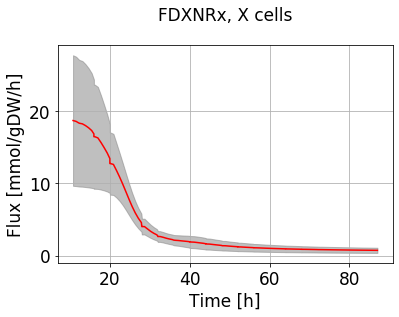

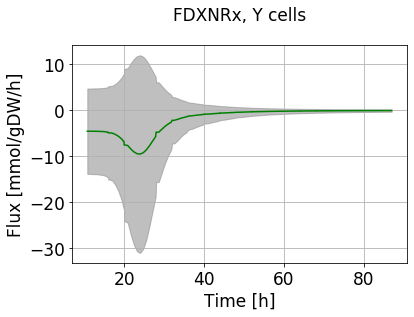

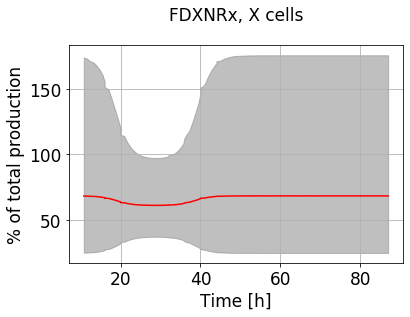

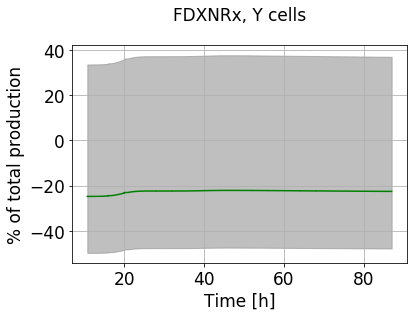

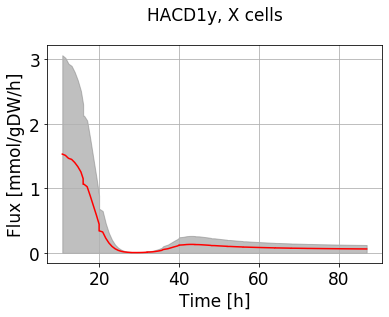

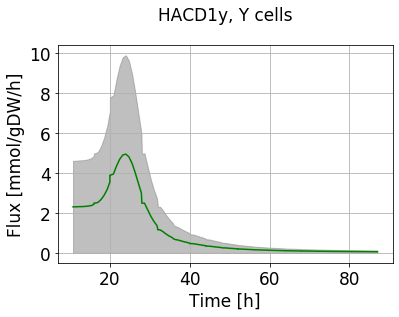

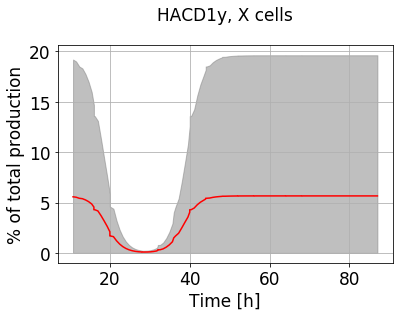

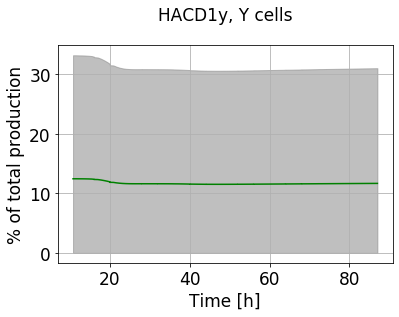

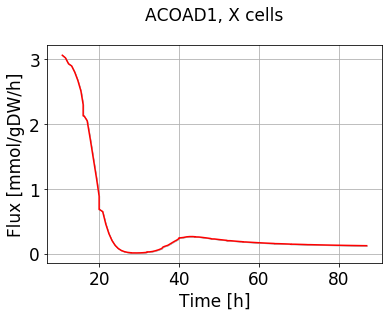

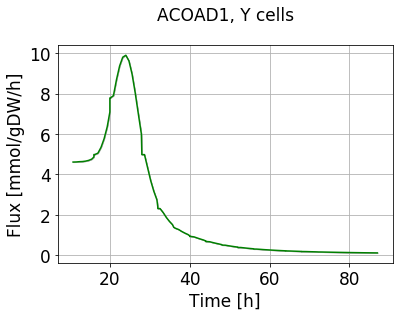

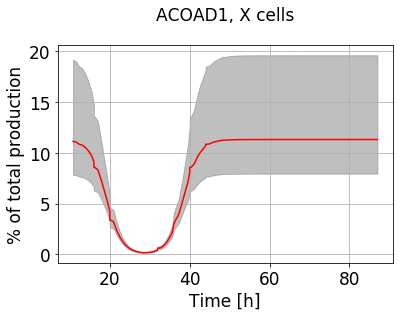

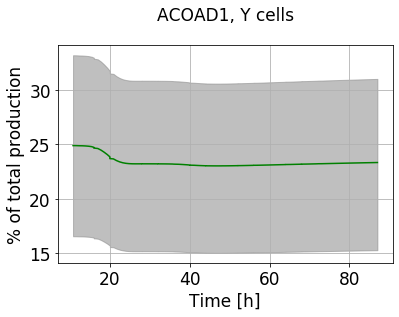

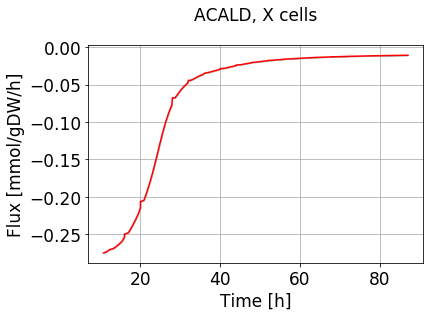

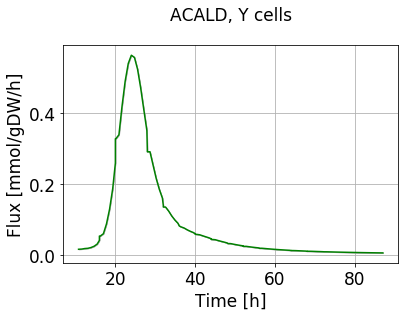

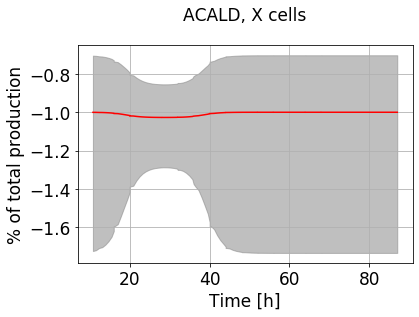

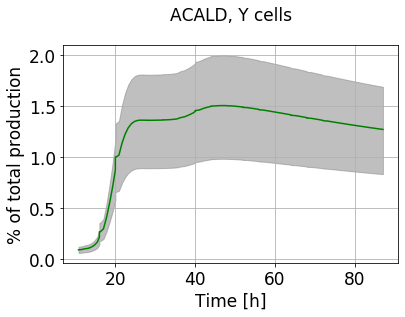

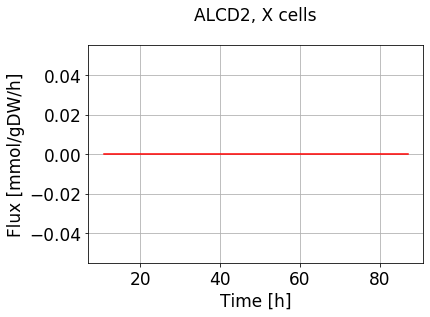

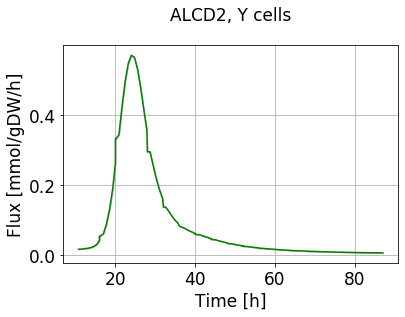

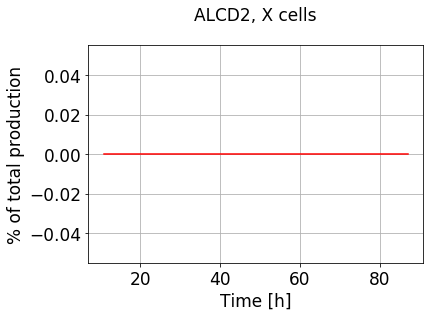

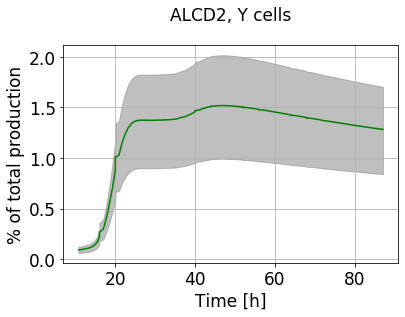

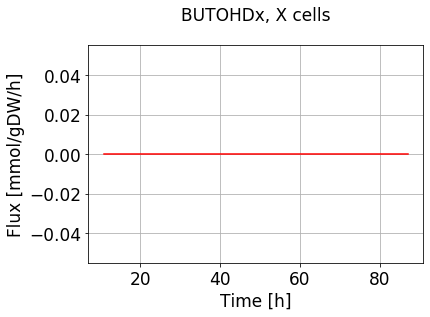

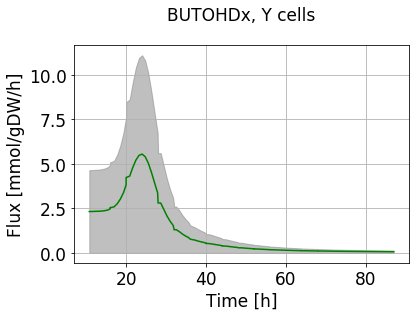

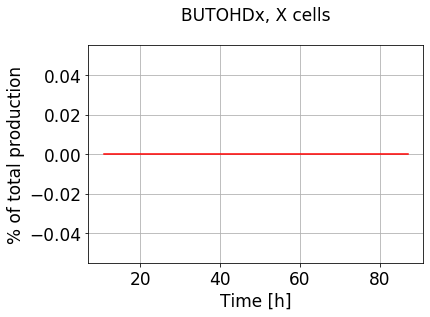

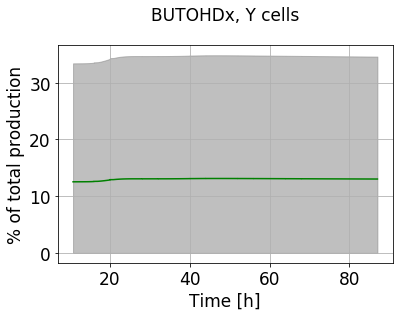

In [10]:
pathName="SolventsPathwaysNAD"
reactions=pathways[pathName]

boundsX = getBounds("X",xfluxes_path,modelX,reactions)
boundsY = getBounds("Y",yfluxes_path,modelY,reactions)        

# Positive fluxes
for i,reaction in enumerate(reactions):
    direction = reactions[reaction]
    meanXs,lbXs,ubXs = getFluxes(reaction,direction,boundsX)
    meanYs,lbYs,ubYs = getFluxes(reaction,direction,boundsY)    
    #Plot by reaction
    plt.figure()
    plt.fill_between(time[1:],lbXs, ubXs,color="grey",alpha=0.5)
    plt.plot(time[1:],meanXs, color="red")
    plt.ylabel("Flux [mmol/gDW/h]")
    plt.xlabel("Time [h]")    
    plt.title(reaction+", X cells")
    plt.grid()
    plt.savefig(reaction+"_"+pathName+"_X.png")

    plt.figure()
    plt.fill_between(time[1:],lbYs, ubYs,color="grey",alpha=0.5)
    plt.plot(time[1:],meanYs, color="green")
    plt.ylabel("Flux [mmol/gDW/h]")
    plt.xlabel("Time [h]")    
    plt.title(reaction+", Y cells")
    plt.grid()  
    plt.savefig(reaction+"_"+pathName+"_Y.png")

    # Plot fractions by reaction 
    fracX=meanXs/posProdX*100    
    fracY=meanYs/posProdY*100 
    lbFracX = lbXs/ubPosProdX*100
    ubFracX = ubXs/lbPosProdX*100
    lbFracY = lbYs/ubPosProdY*100
    ubFracY = ubYs/lbPosProdY*100      
        
    plt.figure()
    #plt.ylim(-100,100)
    plt.plot(time[1:],fracX, color="red")
    plt.fill_between(time[1:],lbFracX, ubFracX,color="grey",alpha=0.5)
    plt.title(reaction+", X cells")
    plt.ylabel("% of total production")
    #plt.ylim(0,100)
    plt.xlabel("Time [h]")
    plt.grid()
    plt.savefig(reaction+"_"+pathName+"_percX.png")     
    plt.figure()
    #plt.ylim(-100,100)
    plt.plot(time[1:],fracY, color="green")
    plt.fill_between(time[1:],lbFracY, ubFracY,color="grey",alpha=0.5)    
    plt.title(reaction+", Y cells")
    plt.ylabel("% of total production")
    plt.xlabel("Time [h]")
    plt.grid()
    plt.savefig(reaction+"_"+pathName+"_percY.png")   

    if i==0:
        meanXsT = meanXs
        meanYsT = meanYs 
        lbXsT = lbXs
        lbYsT = lbYs
        ubXsT = ubXs
        ubYsT = ubYs
    else:
        meanXsT += meanXs
        meanYsT += meanYs 
        lbXsT += lbXs
        lbYsT += lbYs
        ubXsT += ubXs
        ubYsT += ubYs  

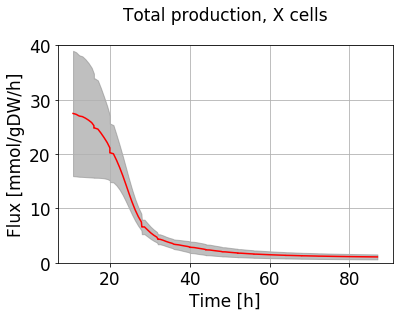

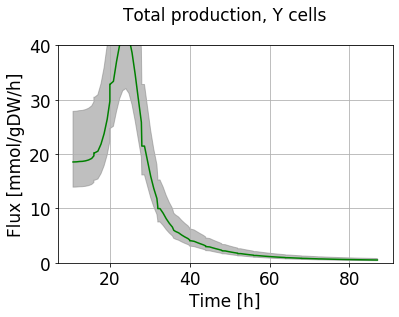

In [11]:
# Sum of all positive fluxes

plt.figure()
plt.ylim(0,40)
plt.plot(time[1:],posProdX, color="red")
plt.fill_between(time[1:],lbPosProdX, ubPosProdX,color="grey",alpha=0.5)
plt.title("Total production, X cells")
plt.ylabel("Flux [mmol/gDW/h]")
plt.xlabel("Time [h]")
plt.grid() 
plt.savefig(pathName+"_totalX.png") 

plt.figure()
plt.ylim(0,40)
plt.plot(time[1:],posProdY, color="green")
plt.fill_between(time[1:],lbPosProdY, ubPosProdY,color="grey",alpha=0.5)
plt.title("Total production, Y cells")
plt.ylabel("Flux [mmol/gDW/h]")
plt.xlabel("Time [h]")
plt.grid() 
plt.savefig(pathName+"_totalY.png")

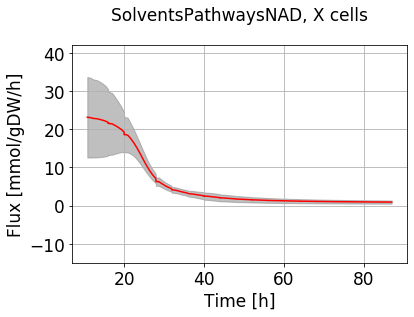

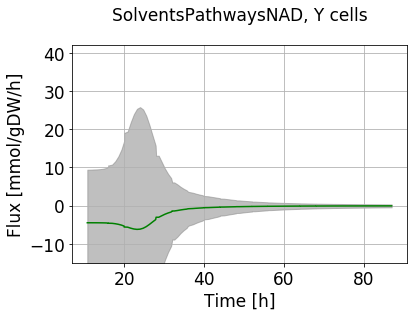

In [12]:
# Net flux
plt.figure()
plt.ylim(-15,42)
plt.fill_between(time[1:],lbXsT, ubXsT,color="grey",alpha=0.5)
plt.plot(time[1:],meanXsT, color="red")
plt.title(pathName+", X cells")
plt.ylabel("Flux [mmol/gDW/h]")
plt.xlabel("Time [h]")
plt.grid()
plt.savefig(pathName+"_allRxnsX.png")
plt.figure()
plt.ylim(-15,42)
plt.fill_between(time[1:],lbYsT, ubYsT,color="grey",alpha=0.5)
plt.plot(time[1:],meanYsT, color="green")
plt.title(pathName+", Y cells")
plt.ylabel("Flux [mmol/gDW/h]")
plt.xlabel("Time [h]")
plt.grid()
plt.savefig(pathName+"_allRxnsY.png")

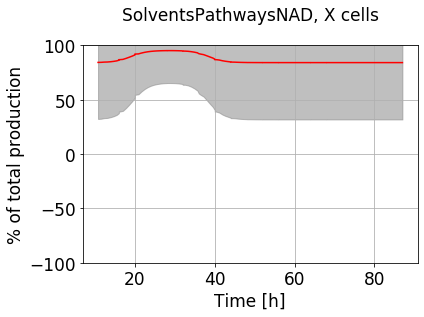

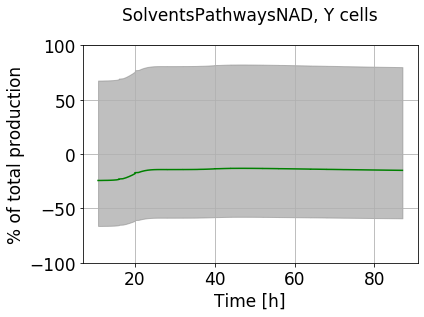

In [13]:
# Net flux prodution as % of total production by all reactions of the metabolism
fracXsT=meanXsT/posProdX*100    
fracYsT=meanYsT/posProdY*100 
lbFracXsT = lbXsT/ubPosProdX*100
ubFracXsT = ubXsT/lbPosProdX*100
lbFracYsT = lbYsT/ubPosProdY*100
ubFracYsT = ubYsT/lbPosProdY*100

plt.figure()
plt.ylim(-100,100)
plt.plot(time[1:],fracXsT, color="red")
plt.fill_between(time[1:],lbFracXsT, ubFracXsT,color="grey",alpha=0.5)
plt.title(pathName+", X cells")
plt.ylabel("% of total production")
plt.xlabel("Time [h]")
plt.grid()
plt.savefig(pathName+"_allRxnsPercX.png")
plt.figure()
plt.ylim(-100,100)
plt.plot(time[1:],fracYsT, color="green")
plt.fill_between(time[1:],lbFracYsT, ubFracYsT,color="grey",alpha=0.5)
plt.title(pathName+", Y cells")
plt.ylabel("% of total production")
plt.xlabel("Time [h]")
plt.grid()
plt.savefig(pathName+"_allRxnsPercY.png")